In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import line_data
from astropy import constants
import astropy.units as u
import synth
import pymoog
import rulerwd
import os
import re

MOOG_path = '{}/.pymoog/moog_nosm/moog_nosm_NOV2019/'.format(os.environ['HOME'])
MOOG_run_path = '{}/.pymoog/rundir/'.format(os.environ['HOME'])

Module "telfit" is not installed, module "telfit_wrapper" cannot be used. Don't try it :-)


In [24]:
s = pymoog.synth.synth(5000, 4.0, 0, 11045.599-6, 11045.599+5, 28000, line_list='vald_11000_24000')
s.prepare_file(atmosphere=2, lines=4)
s.run_moog(output=True)

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER synth  
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
RAW SYNTHESIS OUTPUT; here is the filename: MOOG.out2                           
SMOOTHED SYNTHESES OUTPUT; here is the filename: MOOG.out3                      
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [23]:
11045.599-5

11040.599

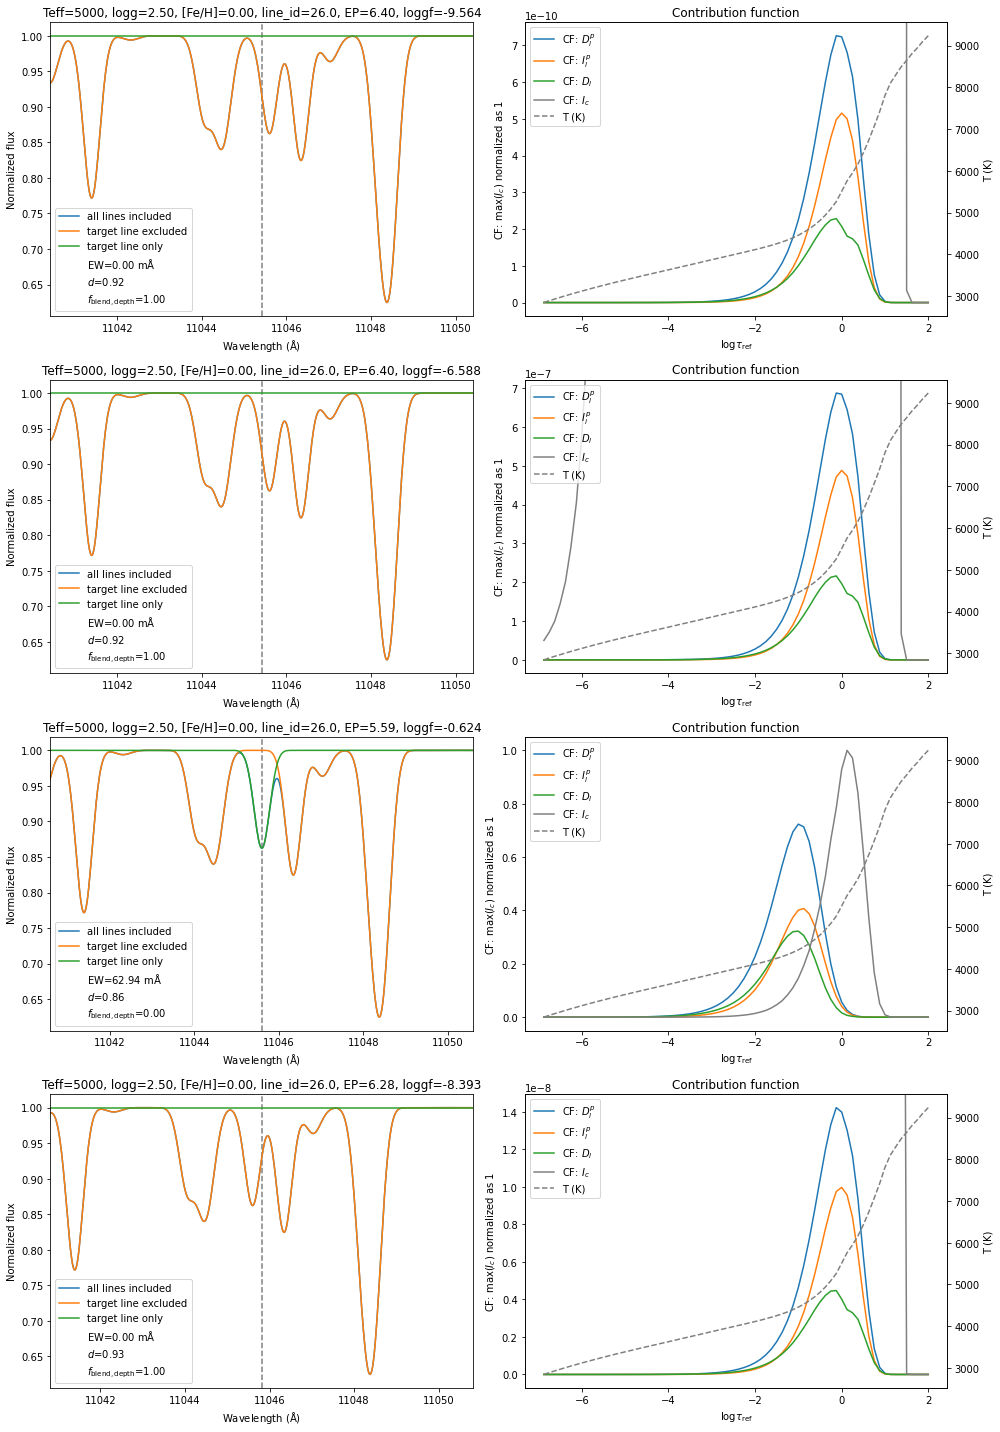

In [21]:
line_wav_input = 11045.599
line_id = 26.0
teff = 5000; logg = 2.5; fe_h = 0 
resolution = 28000
pymoog.contri_func.plot_contri_func(line_wav_input, line_id, teff, logg, fe_h, resolution, 'vald_11000_24000')

## Ionization fraction

In [2]:
# Get partition function from MOOG 

def partition_func_single(partition_func_content):
    Z = int(partition_func_content[1][3:5])
    sep_index = []
    ion_state = []
    for i in range(len(partition_func_content)):
        if 'ionization state' in partition_func_content[i]:
            sep_index.append(i)
            ion_state.append(int(partition_func_content[i].split()[-1]))
    sep_index.append(len(partition_func_content))

    partition_func = {}
    for i in range(len(sep_index)-1):
        partition_func[ion_state[i]] = np.array(''.join(partition_func_content[sep_index[i]+1:sep_index[i+1]]).split(), dtype=float) 

    return Z, partition_func

file = open(MOOG_run_path + 'MOOG.out1', 'r')
out1 = file.readlines()

# Extract the "PARTITION FUNCTION" part
for i in range(len(out1)):
    if 'PARTITION FUNCTIONS' in out1[i]:
        start_index = i
    if 'LINE OPACITIES' in out1[i]:
        end_index = i
partition_func_content = out1[start_index:end_index]

sep_index = []
for i in range(len(partition_func_content)):
    if partition_func_content[i] == '\n':
        sep_index.append(i)

partition_func_all = {}

for i in range(len(sep_index)-1):
    Z, partition_single = partition_func_single(partition_func_content[sep_index[i]:sep_index[i+1]])
    partition_func_all[Z] = partition_single


In [9]:
_, atmosphere = pymoog.contri_func.cal_contri_func(MOOG_run_path + 'MOOG.out1')

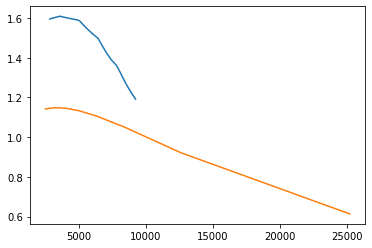

In [17]:
i = 26
plt.plot(atmosphere['T'], partition_func_all[i][1] / partition_func_all[i][0])

theta = np.arange(0.2, 2.1, 0.2)
T = 5040 / theta
p_f0 = np.array([3.76, 2.04, 1.664, 1.519, 1.446, 1.402, 1.372, 1.35, 1.332, 1.317])
p_f1 = np.array([2.307, 1.881, 1.749, 1.682, 1.638, 1.604, 1.575, 1.549, 1.525, 1.504])
plt.plot(T, p_f1/p_f0)

In [ ]:
# Get partition function from OASP